# Tutorial 3 - Comparing Multiple Classifers (SVMs, KNNs, DTs, etc.)

**Course:** SYSC 4906 - Introduction to Machine Learning

**Semester:** Fall 2020

**Adapted by:** [Kevin Dick](https://kevindick.ai/)

**Adapted From:** https://scikit-learn.org/0.15/auto_examples/plot_classifier_comparison.html

---

In this notebook we will explore the process of:
1. generating data (variable difficulty)
2. plotting the data distribution
3. creating multiple classifiers
4. plotting the classifier decision boundaries

**Motivation:** By considering data with different distributions and separability, we can see how various algorithms learn and apply their decision boundaries for each.

**Intuition:** a landscaper has various tools that they can use for moving dirt; these range from trowels to shovels to backhoes to excavators. With no specific problem in mind, we might say that the excavator is the best tool for moving dirt, beacuse it can most the largest volume in the shortest amount of time. If we were show up to a job with our excavator ready to go, but the job was to plant tulips, we would probably wish we would have brought a trowel.

Bringing this back to machine learning, if we neglect to get a sense of how our _data is distributed_, we might reach for the most _computationally expensive_, _complex_ classifier as a catch-all, and find ourselves planting tulips with excavators.


### No Free Lunch Theorem: No silver bullet method that is "the best" for all problems
"states that any two optimization algorithms are equivalent when their performance is averaged across all possible problems"
[*Wolpert, D.H., Macready, W.G. (1997), "No Free Lunch Theorems for Optimization", IEEE Transactions on Evolutionary Computation 1, 67*](https://ti.arc.nasa.gov/m/profile/dhw/papers/78.pdf)

["But every ML algorithm can be represented as a neural network!"](https://towardsdatascience.com/every-machine-learning-algorithm-can-be-represented-as-a-neural-network-82dcdfb627e3)

In this notebook, we will explore four different classifiers and how they perform on artificial datasets with linear and nonlinear class distributions. We are most interested in how the decision boundaries change between various classifiers.

The classifiers we will be looking at are:
- Logistic regression
- Decision tree
- linear SVM
- SVM with a nonlinear kernel
- K-Nearest-Neighbour 

Scikit-learn has a powerful toolboxes for building classifiers, creating artificial data, and visualizing decision boundaries. The toolboxes can be seen in the import calls below.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## 1. Generating Synthetic Data

The first step in building a classifier should always be to look at your data.  It is by looking at our data that we can get a sense of the of the classification problem that we are trying to solve. 

1. **Moons Distribution:** Points randomly generated in a two moon pattern, each moon labeled with a different class.
2. **Circles Distriibution:** Points randomly generated in two concentric circles, each circle labeled with a different class.
3. **~Linearly Separable:** Points randomly generated in a plane that are approximately linearly separable.
4. **Non-Linearly Separable:** Adding uniformly distributed noise to the points in (3) to make non-linearly separable.

In [7]:
# Create 4 datasets of varying difficulty:
# 1) Make a dataset with classes that have either concave-up or concave-down distributions
moons = make_moons(noise=0.3, random_state=0)

# 2) Dataset where classes are distributed in concentric circles
circles= make_circles(noise=0.2, factor=0.5, random_state=1)

# 3) Create two rougly-linearly-separable classes (y) with feature vectors (X) 
#    that are normally distributed about two seed points
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1, class_sep=0.5)

# Makes into the same tuple format as moons and circles
lin_sep = (X, y)

# 4) Add uniformly distributed noise to the linearly separable data
rng = np.random.RandomState(2) # Initialize random number generator
Xn = X + 1 * rng.uniform(size=X.shape)  # Add noise to the feature X
n_lin_sep = (Xn, y)

In [14]:
print(f'Moons:\t\t{type(moons)}\nNum Points:\t{len(moons[0])}')
print(f'Circles:\t{type(circles)}\nNum Points:\t{len(circles[0])}')
print(f'Lin. Sep.:\t{type(lin_sep)}\nNum Points:\t{len(lin_sep[0])}')
print(f'NonLin. Sep.:\t{type(n_lin_sep)}\nNum Points:\t{len(n_lin_sep[0])}')
#moons

Moons:		<class 'tuple'>
Num Points:	100
Circles:	<class 'tuple'>
Num Points:	100
Lin. Sep.:	<class 'tuple'>
Num Points:	100
NonLin. Sep.:	<class 'tuple'>
Num Points:	100


## 2. Plotting the Data Distributions

As always, we should plot our data to better understand the problem and develop an intuition for the type of classifier we should consider. 

**The distribution of the data will help inform the appropriate type of classifier for our problem!**

In [15]:
# Gather all four datasets to iterate over each
datasets = [moons, circles, lin_sep, n_lin_sep]
dataset_names= ["Moons", "Circles", "Linearly Separable", "Noisy Linearly Separable"]

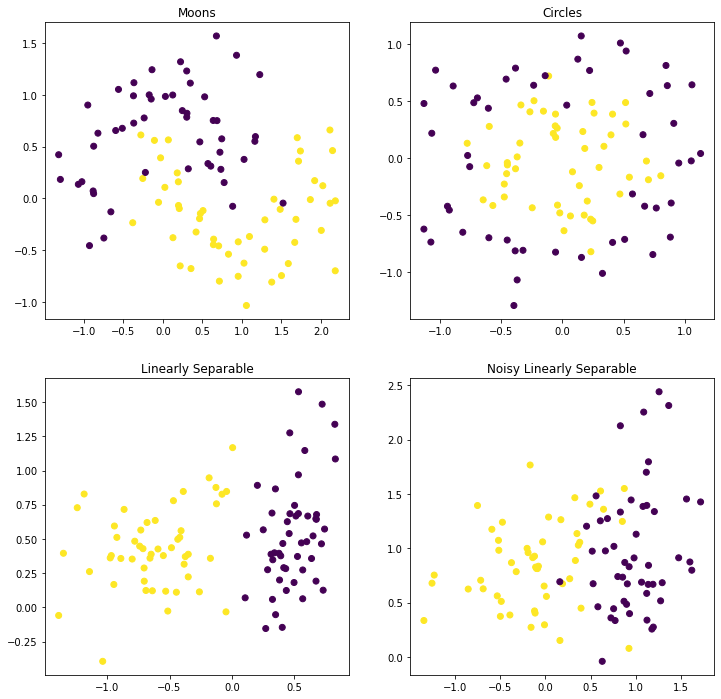

In [18]:
plt.figure(figsize=(12,12))
subplot_dim = (2,2) # For a 2x2 plot
for i in range(len(datasets)):
  #Plot each dataset
  plt.subplot(subplot_dim[0], subplot_dim[1], i+1)
  plt.scatter(datasets[i][0][0:,0], datasets[i][0][0:,1], c=datasets[i][1])
  plt.title(dataset_names[i])



The top two distributions (moons & circles) are generated from non-linear functions. We expect linear-type classifiers to perform more poorly on these datasets, whereas non-linear classifiers are expected to perform better.

The bottom two distributions are generated around a linearly separating boundary (and noise is added). We expect linear methods to separate this distributoin perfectly and all methods too have varying ability to separate the non-linearly separable dataset.

## 3. Creating Multiple Classifiers

We will create five different types of classifiers and demonstrate their ability to create decision boundaries and classify the points from our datasets.

Whenever you want to apply a new learning algorithm, **you should always consult the documentation!**

1. [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#:~:text=Logistic%20Regression%20(aka%20logit%2C%20MaxEnt,is%20set%20to%20'multinomial'.)
2. [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
3. [Support Vector Classifier (linear)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
4. [Support Vector Classifier (non-linear)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
5. [K-Nearest-Neighbour](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [22]:
classifier_names = ["Logistic Regression", "Decision Tree", "Linear SVM", "RBF SVM","KNN"]

classifiers = [
    LogisticRegression(solver='lbfgs'),   # Logistic Regression 
    DecisionTreeClassifier(max_depth=5),  # Decision Tree Classifier (max tree depth of 5)
    SVC(kernel="linear", C=0.025),        # Linear SVM Classifier with C as penalty parameter for misclassified points
    SVC(kernel= 'rbf', gamma=2, C=1.0),   # SVM with radial basis function kernel, gamma is kernel coefficient
    KNeighborsClassifier(3)               # K-Nearest-Neighbours Classifier, looking at three closest points
    ]

#  Hyperparameter Notes:
#     - C is a regularization parameter where the strength of the regularization is 
#       inversely proportional to C. Must be strictly positive. The penalty is a squared L2 penalty.
#     - The Gamma parameter is the inverse of the standard deviation of the RBF kernel 
#       (Gaussian function), which is used as similarity measure between two points. 
#       Intuitively, a small gamma value define a Gaussian function with a large variance

## 4.Compare Performance and Plot the Classifier's Decision Boundaries

Since we have **four** datasets and **five** classifiers, we are making 20 comparisons. For each dataset, the points will be randomly split into a 70% training set and 30% test set.

Critically: the same training and test splits are used to compare each model. If different randomly selected sets are used, a given model may appear to perform better or worse simply due to the random selection of easier or harder samples.

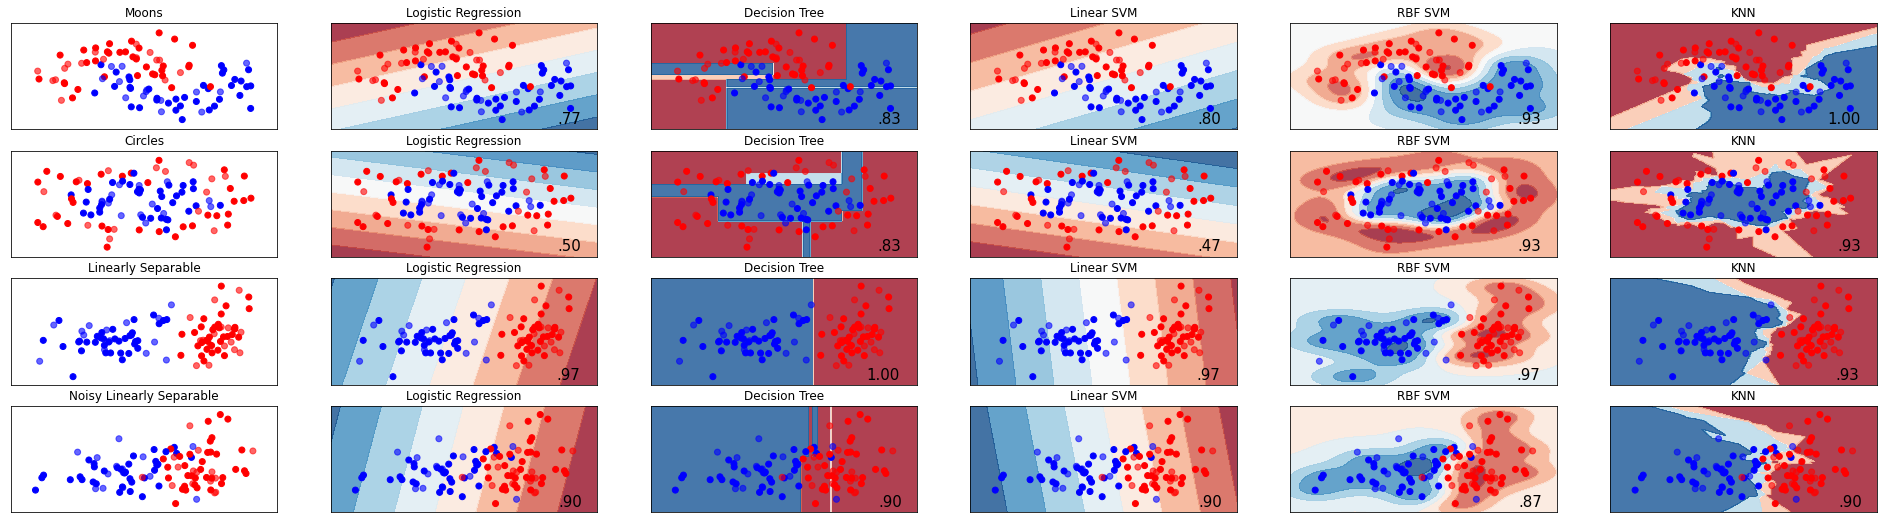

In [23]:
# Useful Plotting Varriables
h = .02  # Resolution in colored mesh visualizations
i = 1    # To keep track of the classifier subplot (column index)
j = 0    # To keep track of the dataset subplots (row index)

figure = plt.figure(figsize=(27, 9))
for ds in datasets:
    
    # Preprocess dataset, split into training and test part
    X, y = ds # X is feature vectors, y is class labels
    X = StandardScaler().fit_transform(X) # Standardize features by removing the mean and scaling to unit variance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) # handy function
    
    # Set plot axis limits
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    # Prepare some nice visualizations
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the datasets in first column
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i, title=dataset_names[j])
    j += 1
    # Plot the training points 
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    
    # Iterate over classifiers ('zip' iterates through two equal-length lists simultaneously)
    for name, clf in zip(classifier_names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        
        # Train and test our classifier
        clf.fit(X_train, y_train) # create classification model using training data
        score = clf.score(X_test, y_test) # evaluate classifier on the testing set

        # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            # flatten xx and yy to 1D arrays and get decision function, or decision boundary hyperplane
            # np.c_ Translates slice objects to concatenation along the second axis.
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) 
        else:
            # if no decision function available, use prediction probability as contrast for contour lines
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] 

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        
        # Plot the testing points (use alpha=0.6 to make them slightly transparent)
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        # Set axes limits
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())

        # Add a title and overlay the prediction score onto the bottom-right corner of the plot
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

### Interpret the Experiment Results

**Row-Wise: Looking across models**
* The KNN perfectly separates the Moons dataset
* Both RBF-SVM and KNN make two miisclassification errors on the Circles dataset
* All models are near-perfect for the Linearly Separable dataset
* All models are ~90% correct for the Noisy/Non-Linearlyy Separable dataset

**Column-Wise: Looking across datasets**
* Logistic Regression better suited to data around a linearlyy-separable boundary
* _Ibid_ for Linear SVMs
* Linear SVM is no better than _random_ for the Circles dataset!
* Decision Trees, RBF-SVM, and KNN all perform relatively "well" accross datasets

**Other Results**
* Decision Trees have large regions of high-confidence (_pure_ leaf nodes)
* Linear SVMs have wider condifence margins in the linear datasets (better generalizability) and smaller margins for the non-linear datasets (less generalizable).

## Take Away Messages

* No Free Lunch Theorem states that **any two optimization algorithms** are **equivalent** when their **performance is averaged** across **all possible problems**.
* The **distribution of the data** will help **inform** the appropriate type of classifier for our problem!
* The moons & circles datasets are **generated from non-linear functions**. We expect **linear-type classifiers to perform more poorly** on these datasets, whereas **non-linear classifiers are expected to perform better**.
* Datasets generatted around a **linearly separating boundary** (made non-linearly separrable by adding noise), we **expect linear methods to separate the first distribution perfectly** and **all methods** to have **varying ability** to separate the **non-linearly separable dataset**.
* Whenever you want to apply a new learning algorithm, **you should always consult the documentation!**
* Based on this experiment, different models will achieve varying levels of performance depending on the structure of the data.


# (Optional) Open-Ended Research-Type Homework
I want to know for each dataset whether one of the algorithms we created produces a **statistically significant** improvement over the others.

1. **Perform a bootstrap experiment for 1,000 iterations**: for each iteration _i_, randomly resplit each dataset, retrain each model, evaluate each on the test set, record the **accuracy** (20 new accuracies for each iteration).
2. **Plot these accuracies using multiple violin plots**: 1,000 for each of the 20 test condition; how did you group your results? why?; how long did each iteration take? how long did this experiment run for? can you measure the time to train each model for each instance? is one model considerably faster/slower than the others?
3. **Determine and apply an appropriate test for statistical significance**: why did you choose the method that you did? do you apply multiple comparison correction? which? why? why not?
4. **Draw conclusions**: can we conclude whether any one algotithm produces a **statistically significant** improvement over the others? is any one algorithm signiifiicantly faster/slower than the others?

Also consider:
* what happens when you modify model **hyperparameters**?
* what happens when you **increase the size** of the datasets?
* what happens when you **decrease the size** of the datasets?
* did you **remove the plotting function**? how does that affect runtime?
* what **compute infrastructure** did you use?
* what **other ML algorithms** could/did you try?
* write up your work in the style of a **TowardsDataScience-like blog post**!

---

If you pursued this, I encourage you to share your results with me!

Email me your notebook + findings: kevin.dick@carleton.ca